<div style="background-color:#00000">
    <img src="https://fundacionsadosky.org.ar/wp-content/uploads/2022/08/logo.png" />
</div>
<div style="background-color:#03030a; margin:20px 40%">
    <img src="https://www.rfindustrial.com/wp-content/uploads/2023/04/cropped-1080x1080_Mesa-de-trabajo-1.png" />
</div>
<div style="background-color:#00000;">
    <img src="https://sinc.unl.edu.ar/wp-content/themes/sinci/img/sinc-logo.png" />
</div>

<p style="font-size: 30px">
    <strong>COPE - “Sistema inteligente de medición de nivel y control de velocidad de bombeo para pozos petrolíferos"</strong>
</p>

<p style="font-size: 20px">
    Objetivo del análisis: Realizar pruebas teóricas sobre la generación de un pulso diferente con propiedas más convenientes para las necesidades planteadas en el proyecto.
</p>

21/07/2023

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt

# Genera un estimulo senoidal con variación esponencial, entre fini y ffin, de
# duracion segundos, con frecuencia de muestreo fs.
# Devuelve
# estimulo, la señal que e debe usar para la medición
# inversa, la señal que convolucionada con la medicion devolverá el resultado
def generaestimulo(fini, ffin, fs, duracion):
    w1 = 2 * math.pi * fini
    w2 = 2 * math.pi * ffin
    T = 1 / fs
    L = duracion / math.log(w2 / w1)
    K = duracion * w1 / math.log(w2 / w1)
    t = np.arange(0, duracion, T)
    estimulo = np.sin(K * (np.exp(t / L) - 1))
    amp = np.exp(-t / L)
    inversa = np.flip(estimulo) * amp
    return estimulo, inversa

Ahora vamos a hacer un ejemplo, suponiendo un modelo lineal simple con cuplas equiespaciadas cada 10 m, y una velocidad del sonido de 340 m/s, se simula una medicion de 0.5 segundos a 16000 hz. Par esta simulacion supongremos que cada cupla genera un eco puntual, y que en cada cupla se pierde 10% de la amplitud de la onda.

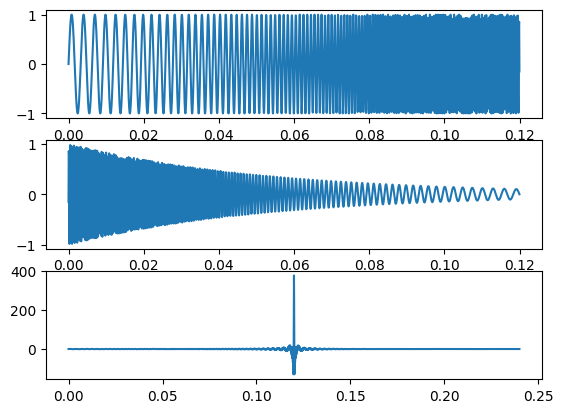

In [2]:
fs = 16000
med_dur = 0.5 #segundos
largo = int(np.fix(med_dur *fs))
med = np.zeros(largo)
espaciado = 10 #metros entre cuplas

#Velocidad del sonido, probar entre 200 y 600
velocidad = 340
esp_muestras = int(np.fix(espaciado*fs/velocidad))
num = int(np.fix(largo/esp_muestras))-1
amp = 1.0
atenuacion = 0.9
for k in range(num):
  med[(k+1)*esp_muestras] = amp
  amp = atenuacion*amp

# cuanto mayor ancho de banda tenga el estimulo, mas parecida a un impulso es la
# deconvolucion, probar aumentando ffin a 8000. El sesultado siempre es un impulso
# pero filtrado en el rango de frecuencias con que se genero el estimulo
fini = 300
ffin = 3000

# Esta es la duracion del estimulo, hay que estudiar si debe durar menos que lo
# que tarda en llegar a la siguiente cupla, en principio no seria necesario, la
# inversa anda igual. En este ejemplo con cuplas cada 10 metros y velocidad 340,
# la separacion es unos 29 ms entre picos, por lo que lo fijo en 20 milisegundos
# para que no se superpongan. Pero probar con  500 milisegundos o sea 0.5
duracion = 0.120 #20 milisegundos
estimulo,inversa = generaestimulo(fini, ffin, fs, duracion)
plt.subplot(311)
t= np.arange(estimulo.shape[0])/fs
plt.plot(t,estimulo)
plt.subplot(312)
plt.plot(t,inversa)
plt.subplot(313)
res = np.convolve(estimulo,inversa)
t=np.arange(res.shape[0])/fs
plt.plot(t,res)


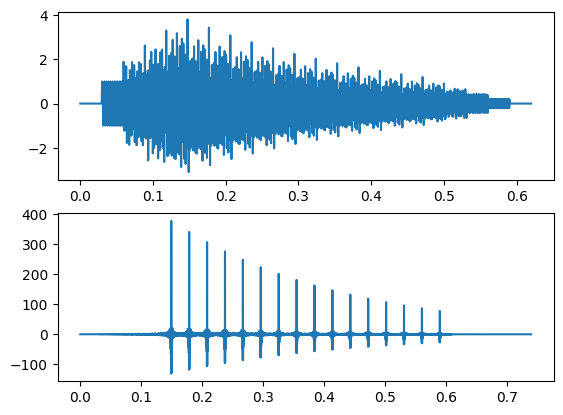

In [3]:
# se simula la transmision con cuplas equiespaciadas
medicion = np.convolve(med,estimulo)

# se deconvoluciona usando la inversa para determinar la posición de las cuplas
posicion = np.convolve(medicion,inversa)



t1 = np.arange(medicion.shape[0])/fs
plt.subplot(211)
plt.plot(t1,medicion)
t2 = np.arange(posicion.shape[0])/fs
plt.subplot(212)
plt.plot(t2,posicion)


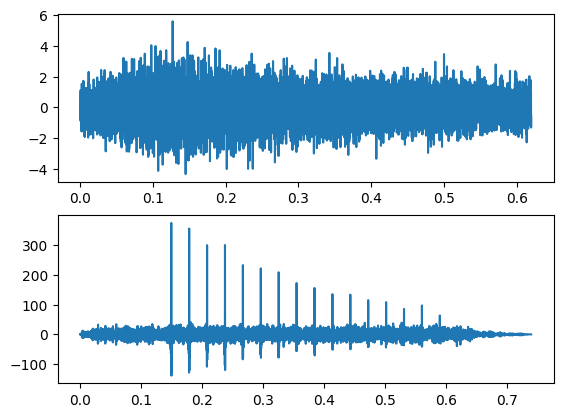

In [4]:
# Ahora agrego ruido a la medicion a ver que sucede
medicion1 = medicion + 0.8*np.random.randn(medicion.shape[0])

posicion1 = np.convolve(medicion1,inversa)
plt.subplot(211)
plt.plot(t1,medicion1)
plt.subplot(212)
plt.plot(t2,posicion1)


Ahora vamos a simular lo mismo pero con el pulso actual de medición, con los parámetros tipicos que se usan

In [5]:
import struct

with open('tabla_seno.bin', 'rb') as file:
    bytes = file.read()
    tabla_seno = struct.unpack('{}H'.format(len(bytes) // 2), bytes)

Frec1 =  301
IncF =  40
Nciclos =  5
Down =  32

In [6]:
# Se define la frecuencia inicial de la señal senoidal
f = Frec1
# Se crea una lista vacía que se llenará con los valores de la señal muestreada
dMuestra = []
# Se inicializan las variables de iteración
inter = 0
paso = Down // 32
# Se ejecuta un ciclo para generar la señal senoidal
for i in range(Nciclos):
    j = 0
    # Se recorre la tabla de valores precalculados de la función seno
    while j < len(tabla_seno):
        # Se verifica si se debe tomar una muestra en este punto
        if inter % paso == 0:
            # Se obtiene el valor de la función seno en este punto
            y = tabla_seno[j]
            # Se agrega el valor de la muestra a la lista
            dMuestra.append(y)
        # Se avanza al siguiente punto de la señal
        j += f
        # Se incrementa el índice que se utiliza para verificar si se debe tomar una muestra
        inter += 1
    # Se recorre la tabla de valores precalculados de la función seno en sentido inverso
    while j < 2 * len(tabla_seno):
        # Se verifica si se debe tomar una muestra en este punto
        if inter % paso == 0:
            # Se obtiene el valor de la función seno en este punto y se invierte su signo
            y = -tabla_seno[j - len(tabla_seno)]
            # Se agrega el valor de la muestra a la lista
            dMuestra.append(y)
        # Se avanza al siguiente punto de la señal
        j += f
        # Se incrementa el índice que se utiliza para verificar si se debe tomar una muestra
        inter += 1
    # Se ajusta el índice para reiniciar la generación de la señal en la tabla de valores
    j -= 2 * len(tabla_seno)
    # Se incrementa la frecuencia de la señal para el siguiente ciclo
    f += IncF

In [7]:
Senial_entrada = np.array(dMuestra)/1000.0
print(len(Senial_entrada))

442


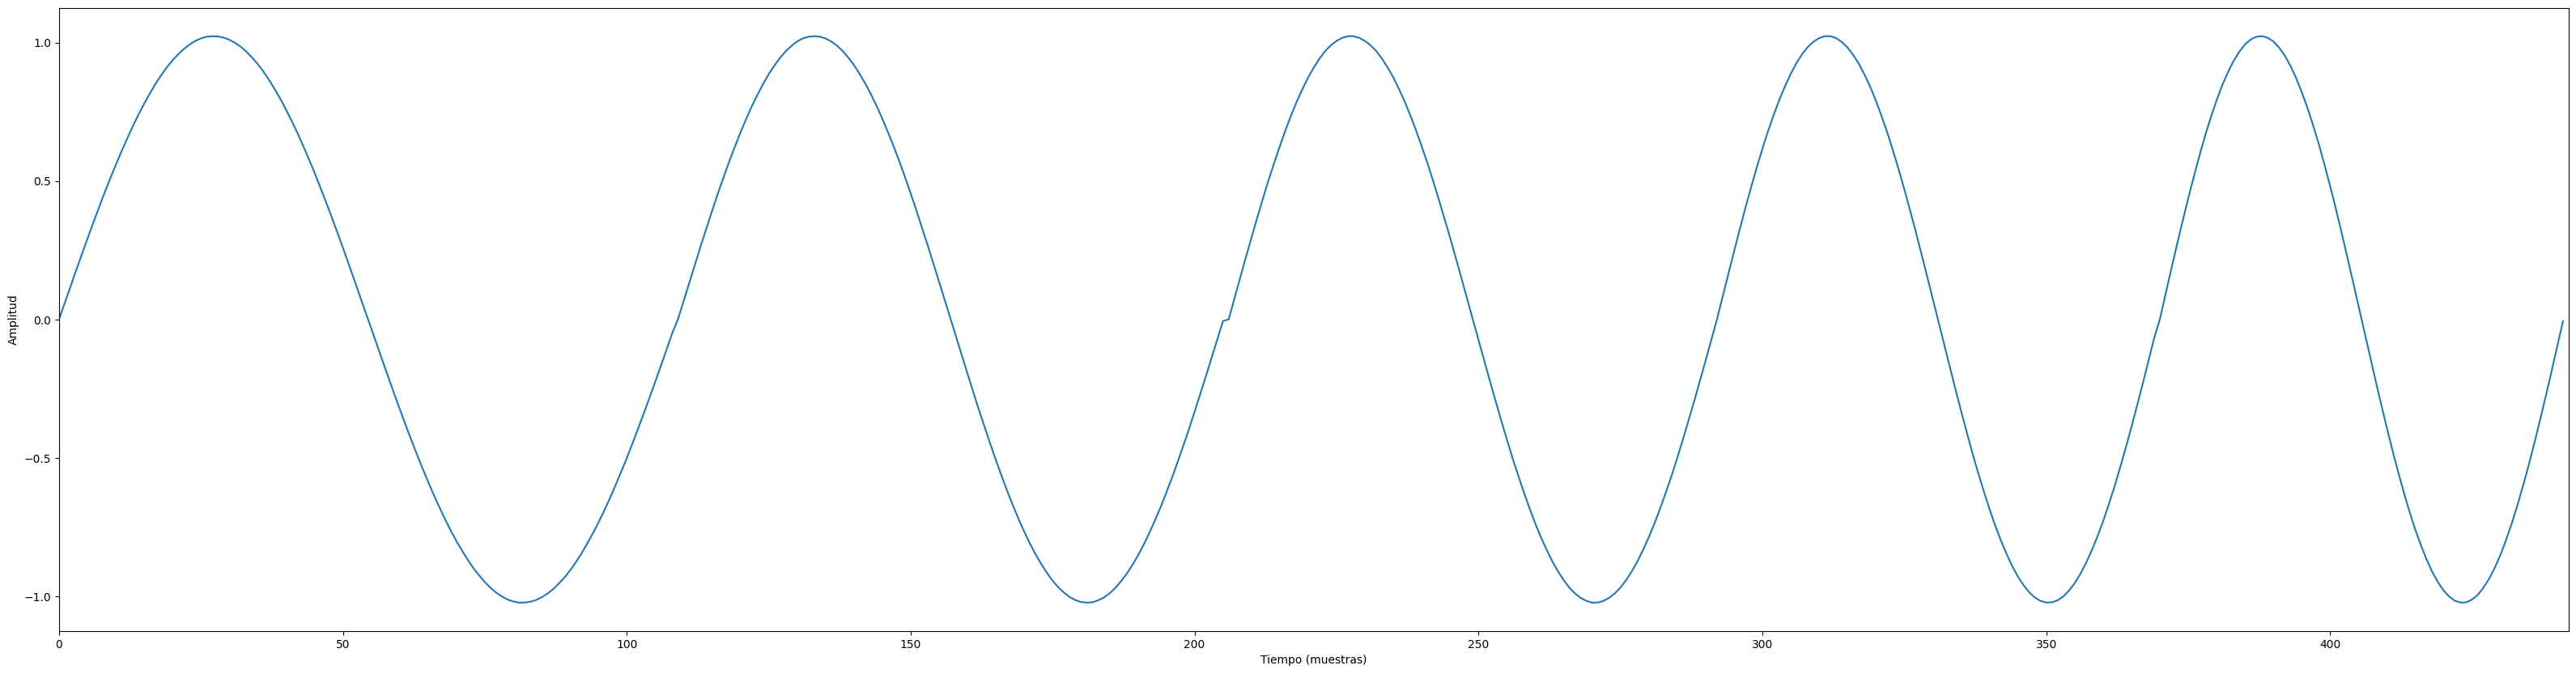

In [8]:
# Graficar señal
fig, ax = plt.subplots(figsize=(40, 10))
ax.plot(Senial_entrada) # agregar datos a la gráfica
ax.set_xlim([0, len(Senial_entrada)]) # establecer límites del eje x
plt.xlabel('Tiempo (muestras)')
plt.ylabel('Amplitud')
plt.show()


Ahora convoliucionamos este estimulo para obtener la "medición"

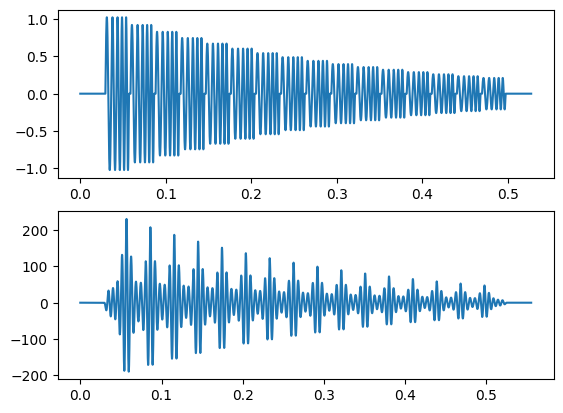

In [9]:
medicion2 = np.convolve(med,Senial_entrada)

# ahora uso la correlacion para encontrar las posiciones de las cuplas

posicion2 = np.correlate(medicion2,Senial_entrada,mode='full')

t1 = np.arange(medicion2.shape[0])/fs
plt.subplot(211)
plt.plot(t1,medicion2)
t2 = np.arange(posicion2.shape[0])/fs
plt.subplot(212)
plt.plot(t2,posicion2)

Ahora mezclamos ruido para verificar la robustez

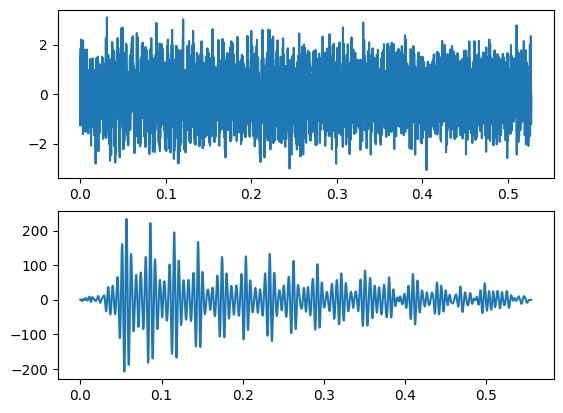

In [10]:
medicion3 = medicion2 + 0.8*np.random.randn(medicion2.shape[0])

posicion3 = np.correlate(medicion3,Senial_entrada,mode='full')
plt.subplot(211)
plt.plot(t1,medicion3)
plt.subplot(212)
plt.plot(t2,posicion3)
